# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

ModuleNotFoundError: No module named 'matplotlib'

# 2. Load Dataset

In [ ]:
df = pd.read_csv('agoda_reviews.csv')  # Replace with your actual file name
print("Dataset Shape:", df.shape)
df = df[['content', 'score']]
df.dropna(inplace=True)
df.head()

Dataset Shape: (14492, 11)


,content,score
0,Good apps,5.0
1,PARAH!!! refund hotel sudah lebih dari 40 hari...,1.0
2,good,3.0
3,agoda kembalikan uang saya. refund Januari 202...,1.0
4,"1. Proses Refund Terlalu Lama, Harus Tunggu 3-...",1.0


# 3. Labeling Sentiment

In [2]:
def label_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score == 3:
        return 'neutral'
    else:
        return 'negative'

df['label'] = df['score'].apply(label_sentiment)

NameError: name 'df' is not defined

# 4. Text Preprocessing & EDA (wordcloud)

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    text = " ".join([word for word in text.split() if word not in stopwords.words('indonesian')])
    return text

df['clean_text'] = df['content'].apply(clean_text)

In [ ]:
def show_wordcloud_by_sentiment(df, label, color='Blues'):
    """
    Menampilkan word cloud berdasarkan label sentimen
    """
    # Gabungkan semua teks dari label tertentu
    # Mengganti 'sentiment' dengan 'label' untuk mencocokkan nama kolom yang ada
    text = ' '.join(df[df['label'] == label]['clean_text'])

    # Buat word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=color,
        stopwords=stop_words,
        max_words=200
    ).generate(text)

    # Tampilkan
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud untuk Sentimen {label.capitalize()}", fontsize=16)
    plt.show()

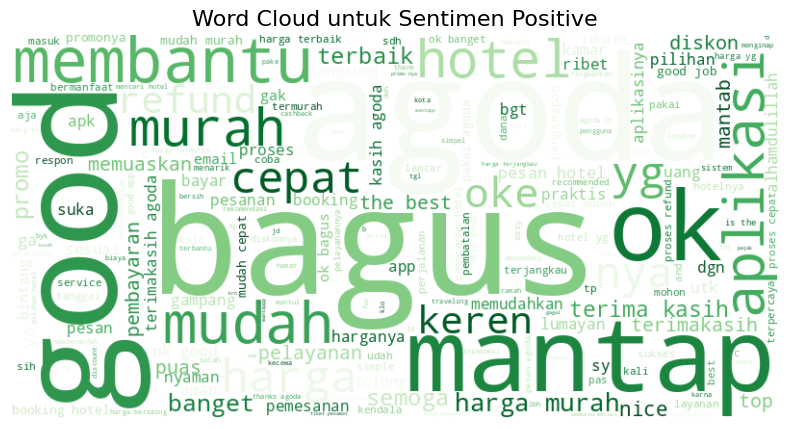

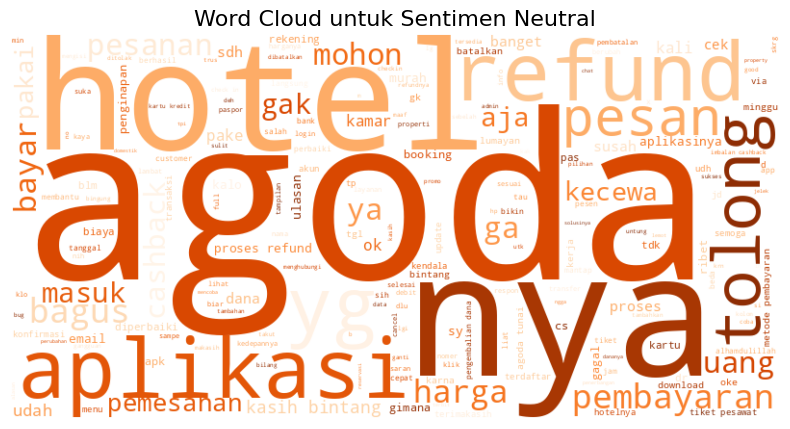

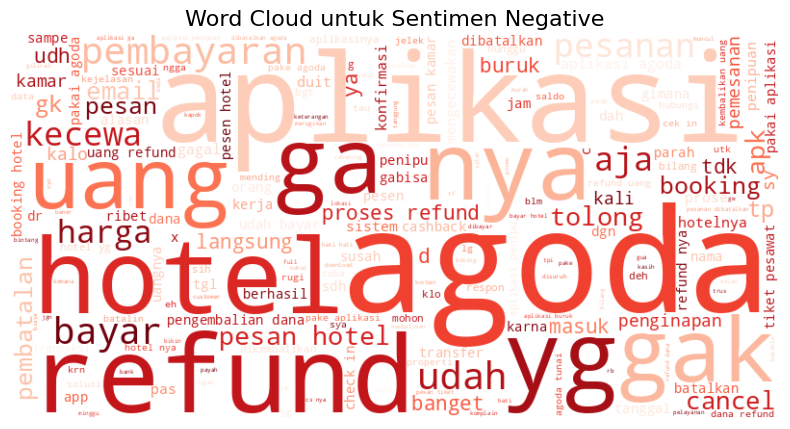

In [ ]:
# Define the stop_words variable using NLTK's Indonesian stopwords
stop_words = set(stopwords.words('indonesian'))

show_wordcloud_by_sentiment(df, 'positive', color='Greens')
show_wordcloud_by_sentiment(df, 'neutral', color='Oranges')
show_wordcloud_by_sentiment(df, 'negative', color='Reds')

# 5. Feature Extraction

In [ ]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['clean_text'])

# Label encoding
le = LabelEncoder()
# Change 'sentiment' to 'label' to match the existing column name
y = le.fit_transform(df['label'])

# 6. Train-Test Split

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# 7. Model Training

## Model Umum

In [ ]:
# Init model
models = {
    "logreg": LogisticRegression(max_iter=200),
    "nb": MultinomialNB(),
    "svm": SVC(),
    "rf": RandomForestClassifier()
}

# Train semua model klasik
trained_models = {}
y_preds_classic = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model
    y_preds_classic[name] = model.predict(X_test)


## Tokenizer & Padding (untuk LSTM)

In [ ]:
# Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
X_seq = tokenizer.texts_to_sequences(df['clean_text'])

# Padding
max_len = 100
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# One-hot label
y_cat = to_categorical(y)

# Train-test split untuk DL
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_pad, y_cat, test_size=0.2, stratify=y, random_state=42)

## Train LSTM

In [ ]:
# LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=5000, output_dim=64, input_length=max_len))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(3, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
history = model_lstm.fit(X_train_dl, y_train_dl, epochs=5, batch_size=64, validation_data=(X_test_dl, y_test_dl))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


182/182 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.4925 - loss: 0.8278 - val_accuracy: 0.5178 - val_loss: 0.7913
Epoch 2/5
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.5239 - loss: 0.7924 - val_accuracy: 0.4574 - val_loss: 0.7943
Epoch 3/5
182/182 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5126 - loss: 0.7889 - val_accuracy: 0.5178 - val_loss: 0.7925
Epoch 4/5
182/182 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.5002 - loss: 0.7988 - val_accuracy: 0.5178 - val_loss: 0.7919
Epoch 5/5
182/182 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.5228 - loss: 0.7792 - val_accuracy: 0.5178 - val_loss: 0.7925


# 8. Evaluation

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

print("=== Evaluation of Classic Models ===")
for name, y_pred in y_preds_classic.items():
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=le.classes_))


=== Evaluation of Classic Models ===

Model: logreg
Accuracy: 0.9147982062780269
              precision    recall  f1-score   support

    negative       0.91      0.94      0.93      1501
     neutral       0.00      0.00      0.00        72
    positive       0.92      0.93      0.92      1326

    accuracy                           0.91      2899
   macro avg       0.61      0.63      0.62      2899
weighted avg       0.89      0.91      0.90      2899


Model: nb
Accuracy: 0.8792687133494308
              precision    recall  f1-score   support

    negative       0.84      0.96      0.90      1501
     neutral       0.00      0.00      0.00        72
    positive       0.94      0.83      0.88      1326

    accuracy                           0.88      2899
   macro avg       0.59      0.60      0.59      2899
weighted avg       0.86      0.88      0.87      2899


Model: svm
Accuracy: 0.917902725077613
              precision    recall  f1-score   support

    negative       0.8

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
# Predict dan evaluasi
loss, acc = model_lstm.evaluate(X_test_dl, y_test_dl)
print("\nModel: LSTM")
print("Accuracy:", acc)

# Optional: classification report (dengan decode label)
y_pred_lstm = model_lstm.predict(X_test_dl)
y_pred_labels = y_pred_lstm.argmax(axis=1)
y_true_labels = y_test_dl.argmax(axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5050 - loss: 0.7957

Model: LSTM
Accuracy: 0.5177647471427917
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
              precision    recall  f1-score   support

    negative       0.52      1.00      0.68      1501
     neutral       0.00      0.00      0.00        72
    positive       0.00      0.00      0.00      1326

    accuracy                           0.52      2899
   macro avg       0.17      0.33      0.23      2899
weighted avg       0.27      0.52      0.35      2899



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 9. Inference (Optional)